# **BIKE RENTAL PREDICTION**
In this project, I will be attempting to predict the total number of people who rent bikes in a given hour. 

The data that I will use was compiled by [Hadi Fanaee-T](http://www.liaad.up.pt/area/fanaee) at the [University of Porto](http://www.up.pt/) and is available as a CSV file. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. The data can be dowloaded from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

***Below is a description of the relevant columns:***

 

*   **instant** - A unique sequential ID number for each row
*   **dteday** - The date of the rentals
*   **season** - The season in which the rentals occurred
*   **yr** - The year the rentals occurred
*   **mnth** - The month the rentals occurred
*   **hr** - The hour the rentals occurred
*   **holiday** - Whether or not the day was a holiday
*   **weekday** - The day of the week (as a number, 0 to 7)
*   **workingday** - Whether or not the day was a working day
*   **weathersit** - The weather (as a categorical variable)
*   **temp** - The temperature, on a 0-1 scale
*   **atemp** - The adjusted temperature
*   **hum** - The humidity, on a 0-1 scale
*   **windspeed** - The wind speed, on a 0-1 scale
*   **casual** - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
*   **registered** - The number of registered riders (people who had already signed up)
*   **cnt** - The total number of bike rentals (casual + registered)

I'll be trying to predict the **cnt** column and will not include **casual** and **registered** columns in the training of the models. I will build **Logistic Regression** and a **Random Forests Regressor** models and and try to combine the models to achieve good predictions


Import libraries

In [88]:
# Libraries for reading and manipulating data
import pandas as pd
import numpy as np

# Libraries for visualizing data
import seaborn as sns
import matplotlib.pyplot as plt

# Libraries for training the models and assessing their performance
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Metrics for assessing performance
from sklearn.metrics import mean_squared_error 

In [89]:
# Read and preview the first five rows of the data
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [90]:
# Check if there are columns with missing values, missing values cause errors
# when training the models and hence have to be dealt with 
bike_rentals.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

correlations between the variables and the target column (cnt) 

In [91]:
data_cols = bike_rentals.columns
sorted_corrs = bike_rentals[data_cols].corr()['cnt'].sort_values()
print(sorted_corrs)
corrmat = bike_rentals[sorted_corrs.index].corr()

hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
yr            0.250495
instant       0.278379
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64


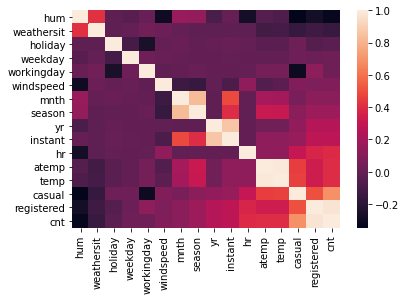

In [92]:
# Plot a correlation heatmap to see whether there are variables that are too
# closely related and may influence the training more
sns.heatmap(corrmat)
plt.show()

In [93]:
'''
From the correlations and the heatmap above the following columns need to be
dropped:
instant - just a unique id
dteday - details captured more accurately in month, season, year
casual - relates directly with the cnt
registered - relates directly with the cnt
temp - relates directly with atemp 
'''

# Drop the 'instant', 'dteday', 'casual' and 'registered' columns
bike_rentals.drop(columns=['instant', 'dteday', 'casual', 'registered', 
                           'temp'], inplace=True)

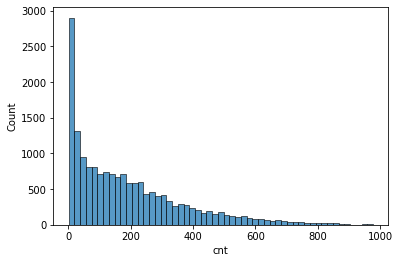

In [94]:
# Histogram to see distribution of bike rentals per hour
sns.histplot(bike_rentals['cnt'])

In [95]:
bike_rentals['cnt'].mean()

189.46308763450142

In [96]:
training_cols = list(bike_rentals.columns)
training_cols.remove('cnt')

# 80% of the rows to be in the training sent and the rest in the testing
train_test_split = round(len(bike_rentals.index) * .8)
# Select the 80% randomly, random_state=1 for reproducibility
train = bike_rentals.sample(train_test_split, random_state=1)
# All rows not in train sent will be in testing set
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]
X_train = train[training_cols]
y_train = train['cnt']
X_test = test[training_cols]
y_test = test['cnt']

# Ensure the testing and training sets are of correct shapes
print(f'Shapes: X_train; {X_train.shape}, y_train; {y_train.shape}, X_test; \
{X_test.shape}, y_test; {y_test.shape}')

Shapes: X_train; (13903, 11), y_train; (13903,), X_test; (3476, 11), y_test; (3476,)


**Train the Linear Regression, Decision Tree Regressor, and Random Forest Regressor models**

In [97]:
results_dict = {}
lr = LinearRegression()
dtr = DecisionTreeRegressor(min_samples_leaf=6)
rfr = RandomForestRegressor(min_samples_leaf=3, min_samples_split=3)
for name, model in [['linear regression', lr], ['decision trees', dtr], 
                    ['random forests', rfr]]:
    model.fit(X_train, y_train)
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    results_dict[name] = [train_rmse, test_rmse]
results_dict

{'decision trees': [36.62237957173966, 54.62631684108824],
 'linear regression': [142.2903332661265, 139.94117854989577],
 'random forests': [27.564146691495992, 45.22395498509029]}

After tweaking the models, the best results achived are as shown above, the **linear regression** model was the most innacurate and on average had rmse of about **140** which was quite high but there was no evidence of overfitting or underfitting

The **Decision Tree Regressor** model was the second best model with rmse on training data of about **36** and rmse on testing data of about **53**, suggesting that the model is overfitting

The **Random Forest Regressor** model was the best with  rmse on training data of about **27** and rmse on testing data of about **44**, also suggesting that the model is overfitting

**Use best performing model to make predictions on test data**

In [98]:
model = RandomForestRegressor(min_samples_leaf=3, min_samples_split=3)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
test2 = test.copy()
test2['predictions'] = predictions

In [99]:
# Sample 10 rows to compare 'cnt' and 'predictions' columns
test2.sample(10)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt,predictions
12170,2,1,5,7,0,0,0,1,0.5606,0.88,0.1642,52,50.056587
6236,3,0,9,10,0,4,1,2,0.5758,0.89,0.2239,120,131.187126
10274,1,1,3,4,0,5,1,3,0.4091,0.66,0.2836,1,3.276766
7924,4,0,12,20,0,4,1,1,0.3485,0.46,0.1045,190,162.423187
12622,2,1,6,3,0,5,1,1,0.5303,0.83,0.1642,5,10.948276
1733,1,0,3,21,0,4,1,1,0.4242,0.62,0.2239,138,103.316357
10640,2,1,3,11,0,6,0,2,0.4848,0.94,0.1940,273,335.084207
13952,3,1,8,13,0,4,1,1,0.7879,0.41,0.1045,281,279.796174
2679,2,0,4,13,0,2,1,1,0.6667,0.51,0.4478,176,160.551599
13401,3,1,7,14,0,2,1,1,0.8333,0.29,0.2537,214,220.571025
